# Introduction

When consistently performing a job on which one develops an expertise, it can be easy to forget to analyse the data created through the jobs one performs.

To this end, the goal of the current project is to analyse the work orders of a Pipe Replacement company, in an attempt to bring insights from it and develop an approach to sistematise.

The project will scope, clean, prepare, analyse, and visualise data, so as to explain the findings made by the analysis, as well as predict the cost of future jobs made by the company. Ultimately, this project is designed to be presented to a team of stakeholders from the company and build an application which would allow users (both internal and external) to interact with the data and access easier invoice estimates.

The reader can find a full written report (in PDF) of this project at: https://drive.google.com/file/d/1psSEx27IxF3kKXZAiitFIO25kknYvQ33/view?usp=sharing

### Table of Contents

* [Project Goals](#goals)
* [Data](#data)
* [Job Cost and other features](#job-cost)
* [Predicting job cost](#prediction)
    - [The XGBoost Algorithm](#XGBoost)
    - [Applying the model](#application)
* [A Tool for Users to Interact With](#tool)
* [Discussion](#discussion)

<a id="goals"></a>
# Project Goals

The main goal of this project is to analyse the jobs done previously by the company and develop a model that will allow users of my application to predict the cost of a future job. Because the main concern of this project will be user accessibility to the data and analysis, the current project has 4 different goals to ensure complete accessibility to the data analysis and model building. These will be:

- Describe the data provided.
- Show how the cost of jobs is related to other features in the data.
- Develop an approach for predicting the cost of a job.
- Wireframe a tool empowering users to interact with any outcomes. - This will be done externaly to this notebook.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import math
from scipy import stats

ModuleNotFoundError: No module named 'xgboost'

<a id="data"></a>
# Data 

The data for this project was provided by the fictitious company for which I am a consultant and is a fictional dataset. The data is comprised entirely of one dataset - Example Work Orders.xlsx.

In [ ]:
df = pd.DataFrame(pd.read_excel("/kaggle/input/pipe-instalation-dataset/Example Work Orders.xlsx"))

# observing the data present in the dataset
print(df.head())

# observing the columns in the dataset
print(df.columns)

# observing the shape of the data
print(df.shape)

This dataset is comprised of 7 columns. These are: JOB_ID - the unique identity of the work order.; JOB_TYPE - the type of job performed; DEPTH_M - the depth of the pipe (m); DIAMETER_MM - the diameter of the pipe (mm); MATERIAL - the material of the pipe; LENGTH_M – the length of the pipe (m); JOB_COST – the cost of the job (£).

## Data Exploration

In [ ]:
# let's start with seeing some summary statistics on the dataset
print(df.describe())

# some of the features are objects and so we need to get the mode and different possible types
print(df[["JOB_TYPE", "MATERIAL"]].mode())

# let's observe how many job types and materials there are
print(df.JOB_TYPE.unique())
print(df.MATERIAL.unique())

# from seeing the summary statistics of the data, it seems there are 6 NaN's in the JOB_COST variable
print(df["JOB_COST"].isna().sum())

# identifying the 6 rows with a NaN Job_Cost. For now, I will leave these like they are.
df_nan = df[df.JOB_COST.isna()]
print(df_nan)

From this we get the following picture on each of the columns:

    - Most common Job_type = Replace
    - Most common Material = AC
    - Average Depth of pipe = 2.67M (+/- 0.85M)
    - Average Diameter of pipe = 733M (+/- 24486MM)
    - Average Length of pipe = 25.13M (+/- 9.1M)
    - Average cost of a job = 10207£ (+/- 9534.84£)
    
## Further Data Exploration

In [ ]:
# firstly, lets see the distribution of jobs
print(df.groupby("JOB_TYPE").size())

As we can see, the most common job by far, is to **Replace** pipes. 

Lets proceed by exploring which Material is the most used in these operations.

In [ ]:
# let's explore the data further, with association analytics

# which material is most commonly used in the two different job types?

job_type_counts = df.groupby(["JOB_TYPE", "MATERIAL"]).count().reset_index().pivot(columns="MATERIAL", index= "JOB_TYPE",
                                                                                  values = "JOB_ID")
job_type_counts.columns = ["AC", "CI", "ST"]

# adding the total sum of jobs done for each type 
jobs = pd.DataFrame(job_type_counts)
jobs["Total_Sum"] = jobs.sum(axis=1)

print(jobs)


Another question that might be interesting to answer is wether the job type has any impact on the pipe size. That is, in Repair type of jobs, the pipe might be bigger on average, thus warranting a repair instead of replacing it entirely. Let's explore this.

In [3]:
# Starting with Length vs Job Type
sns.barplot(data = df, x = "JOB_TYPE", y = "LENGTH_M")
plt.show()
plt.clf()

# Depth vs Job Type
sns.barplot(data = df, x = "JOB_TYPE", y = "DEPTH_M")
plt.show()
plt.clf()

# Diameter vs Job Type
sns.barplot(data = df, x = "JOB_TYPE", y = "DIAMETER_MM")

NameError: name 'df' is not defined

As we can see from the visualisations above, only the diameter seems to change with different types of jobs. However, the confidence seems to be very low as the error is quite significant. As such,, in order to verify if this there is, indeed a difference, we will run a statistical significance test.

### Is there a significant difference in diameter between job types?

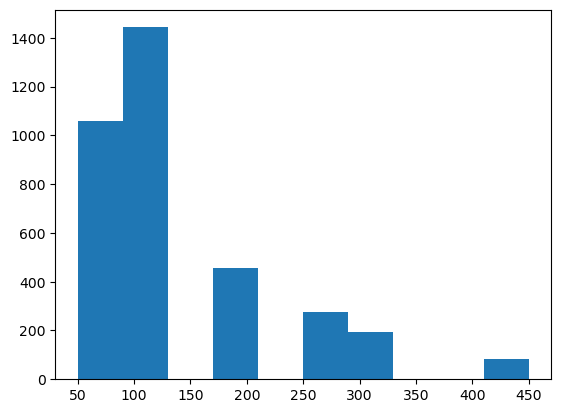

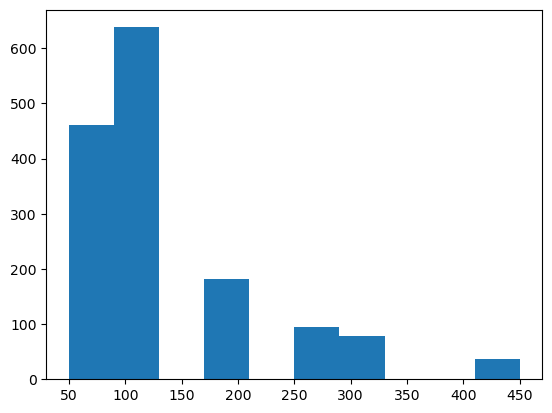

The Mann-Whitney U test returned a 0.375 p-value. Meaning there is no significant difference between the two datasets.


<Figure size 640x480 with 0 Axes>

In [7]:
# making the groups
df_replace = df[df.JOB_TYPE == "Replace"]["DIAMETER_MM"]
df_replace = df_replace[df_replace < 500]
df_repair = df[df.JOB_TYPE == "Repair"]["DIAMETER_MM"]
df_repair = df_repair[df_repair < 500]

# assessing assumptions of normality
plt.hist(df_replace)
plt.show()
plt.clf()

plt.hist(df_repair)
plt.show()
plt.clf()

# because the two sets of data do not follow normality assumptions,
# we will run a Mann-Whitney test

stat, p = stats.mannwhitneyu(df_replace, df_repair)
print(f"The Mann-Whitney U test returned a {round(p, 3)} p-value. Meaning there is no significant difference between the two datasets.")

As can be seen, the Mann-Whitney U test showed that there isn't a significant difference in the diameter of pipes between the Repair and Replace job types. 

Finally, we can do the same tests we just did with job type, but instead with the pipe Material.

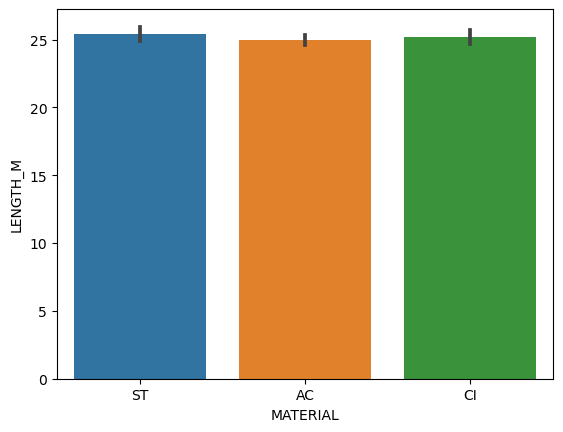

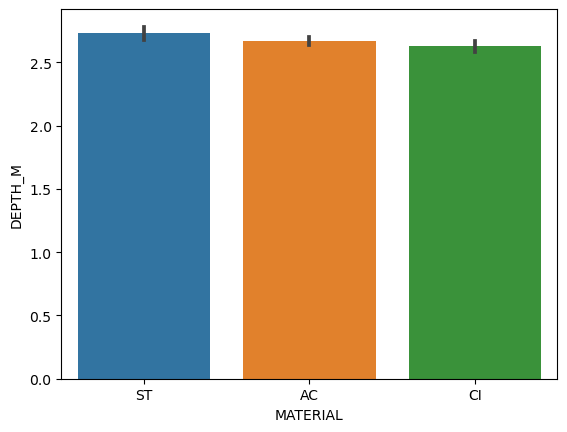

<AxesSubplot:xlabel='MATERIAL', ylabel='DIAMETER_MM'>

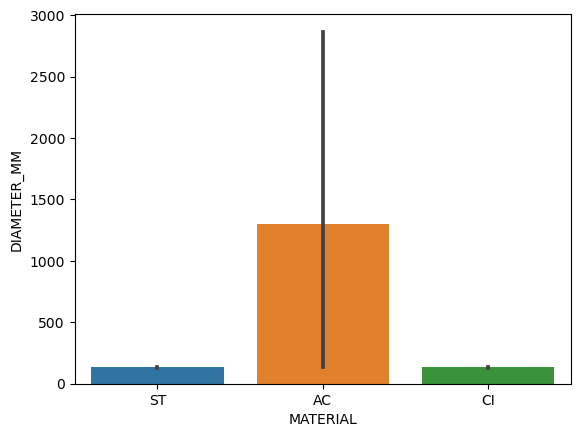

In [8]:
# Starting with Length vs Material
sns.barplot(data = df, x = "MATERIAL", y = "LENGTH_M")
plt.show()
plt.clf()

# Depth vs Material
sns.barplot(data = df, x = "MATERIAL", y = "DEPTH_M")
plt.show()
plt.clf()

# Diameter vs Material
sns.barplot(data = df, x = "MATERIAL", y = "DIAMETER_MM")

Once again, a Mann-Whitney U test will be run between AC and the other two Materials, to check for a significant difference.

In [9]:

st_material = df[df.MATERIAL == "ST"]["DIAMETER_MM"]
ac_material = df[df.MATERIAL == "AC"]["DIAMETER_MM"]
ci_material = df[df.MATERIAL == "CI"]["DIAMETER_MM"]

# ST vs AC
stat, p = stats.mannwhitneyu(st_material, ac_material)
print(f"The Mann-Whitney U test returned a {round(p, 3)} p-value for the difference between ST and AC Material.")

# CI vs AC
stat, p = stats.mannwhitneyu(ci_material, ac_material)
print(f"The Mann-Whitney U test returned a {round(p, 3)} p-value for the difference between CI and AC Material.")

The Mann-Whitney U test returned a 0.617 p-value for the difference between ST and AC Material.
The Mann-Whitney U test returned a 0.55 p-value for the difference between CI and AC Material.


As can be seen above, there is no significant difference between any of the different materials, in terms of average Depth, Length or Diameter of the pipes being installed.

Finally, I would like to explore the relationship between Depth, Length and Diameter, to determine wether there is a relationship between any of them.

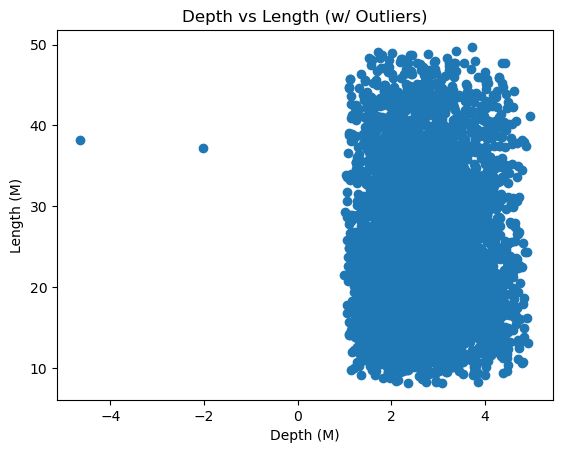

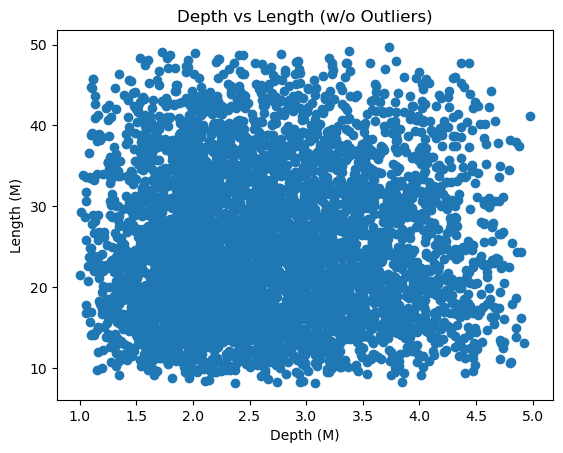

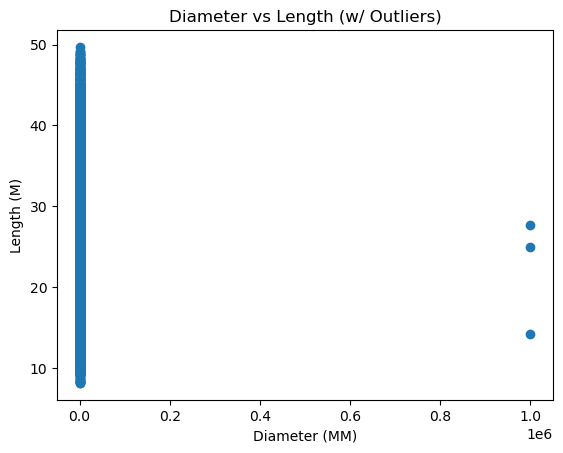

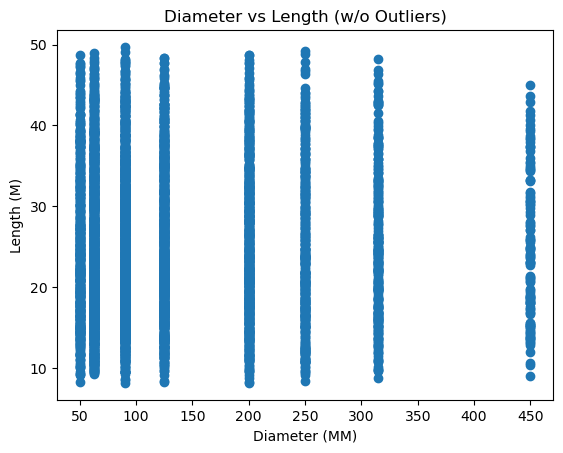

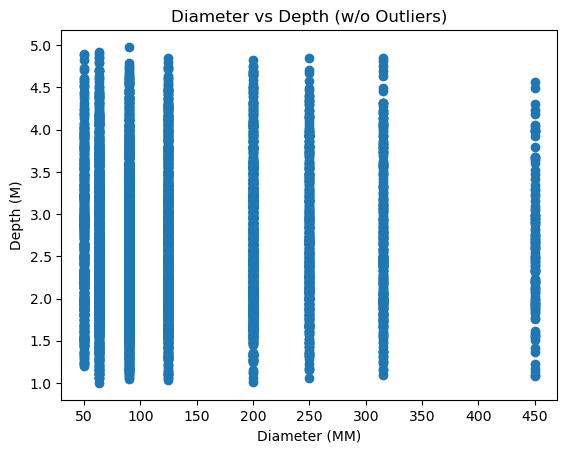

<Figure size 640x480 with 0 Axes>

In [10]:
# Length and Depth
plt.scatter(df["DEPTH_M"], df["LENGTH_M"])
plt.title("Depth vs Length (w/ Outliers)")
plt.xlabel("Depth (M)")
plt.ylabel("Length (M)")
plt.show()
plt.clf()

# in order to correctly assess the depth, 
# we will need to see it without the two (negative) outliers
df_depth = df[df.DEPTH_M > 0]

plt.scatter(df_depth["DEPTH_M"], df_depth["LENGTH_M"])
plt.title("Depth vs Length (w/o Outliers)")
plt.xlabel("Depth (M)")
plt.ylabel("Length (M)")
plt.show()
plt.clf()

# Length and Diameter
plt.scatter(df["DIAMETER_MM"], df["LENGTH_M"])
plt.title("Diameter vs Length (w/ Outliers)")
plt.xlabel("Diameter (MM)")
plt.ylabel("Length (M)")
plt.show()
plt.clf()

# in order to assess this relationship clearly, 
# we will need to remove the outliers present in the diameter feature
df_diameter = df[df.DIAMETER_MM < 500]
plt.scatter(df_diameter["DIAMETER_MM"], df_diameter["LENGTH_M"])
plt.title("Diameter vs Length (w/o Outliers)")
plt.xlabel("Diameter (MM)")
plt.ylabel("Length (M)")
plt.show()
plt.clf()

# Diameter and Depth
df_len_dia = df[(df.DIAMETER_MM < 500) & (df.DEPTH_M > 0)]
plt.scatter(df_len_dia["DIAMETER_MM"], df_len_dia["DEPTH_M"])
plt.title("Diameter vs Depth (w/o Outliers)")
plt.xlabel("Diameter (MM)")
plt.ylabel("Depth (M)")
plt.show()
plt.clf()

As can be seen above, there is no significant relationship between these three pipe features, so as to be able to predict one from the other.

With this, we finished our deep exploration of the data. 

Now, we need to explore how the different features from the dataset impact the cost of jobs, in an effort to be able to predict this variable from changes in the other.

<a id="job-cost"></a>
# How is the cost of a job related to other features?

Because the cost of an operation is entirely dependent on the scope and extension of the job, it is hypothesised that most (if not all) of the features will have a relationship with the "JOB\_COST" variable. This, of course, needs to be analised to be established as a fact, before proceeding forward.

Firstly, we will visualise how the cost of a job differs depending on the type of job and material being used.

0
                       JOB_COST
MATERIAL JOB_TYPE              
AC       Repair     4269.908287
         Replace   12616.665773
CI       Repair     4240.315131
         Replace   12544.600660
ST       Repair     4779.249191
         Replace   13095.169083


Text(0.5, 1.0, 'Job Cost per Intervention Type')

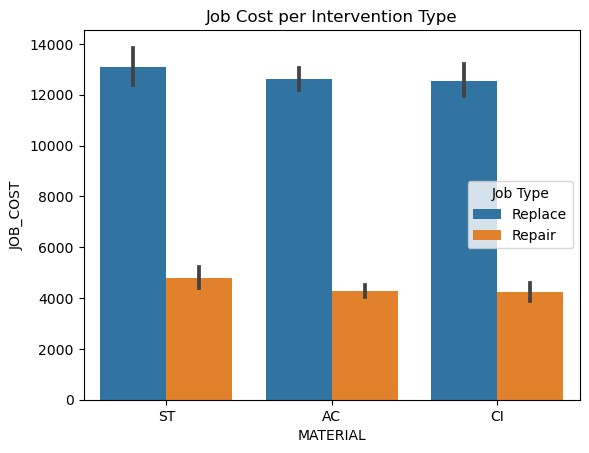

In [11]:
# let's create a new dataframe with NaN, for the data analysis part. We will come back to it further, to replace these values
df_clean = df.drop(df_nan.index)

# this new dataset is clean and has no NaN's
print(df_clean["JOB_COST"].isna().sum())

# lets see which job is the most costly, on average
job_type_cost = df_clean.groupby("JOB_TYPE").JOB_COST.mean()

# now lets observe the cost of job, per material, does it make a difference?
material_cost = df_clean.groupby("MATERIAL").JOB_COST.mean()

# let's visualise how each different job type and material type impacts cost
dfx = pd.DataFrame(df_clean.groupby(["MATERIAL", "JOB_TYPE"]).JOB_COST.mean())
print(dfx)

sns.barplot(data = df_clean, x = 'MATERIAL', y = 'JOB_COST', hue = 'JOB_TYPE')
plt.legend(loc='center right', title = 'Job Type')
plt.title("Job Cost per Intervention Type")

Here, we can see how replacing pipes is the most common job type and the most profitable, on average, being almot 3x as costly for the costumer to Replace than to Repair a pipe. Another insight we get from the visualisation above is that it seems no one material is more costly for the costumer.

Let's continue by exploring how the specific details of the pipe can ultimately impact the cost of the job.

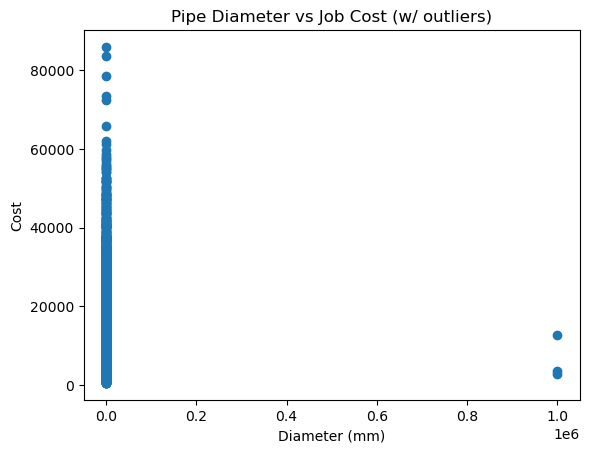

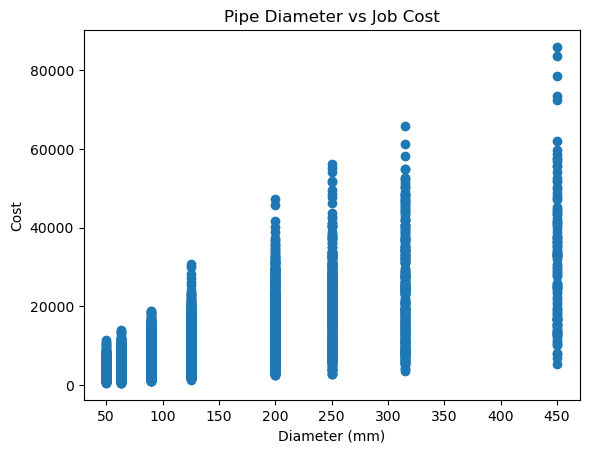

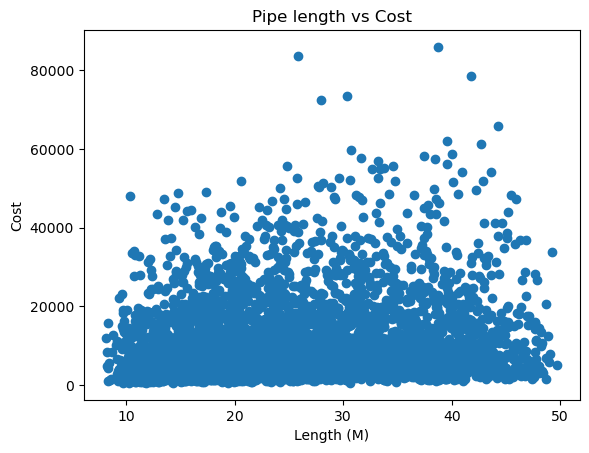

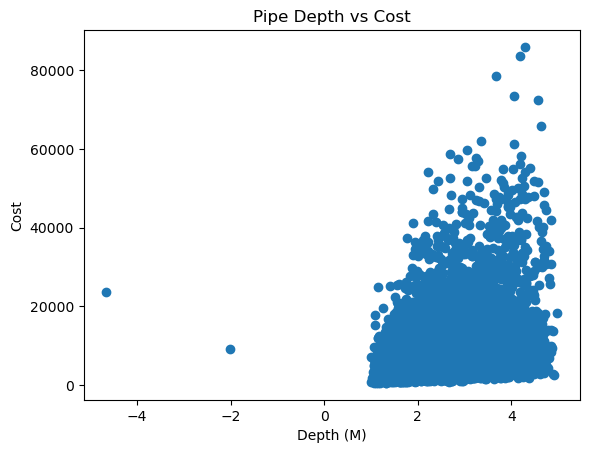

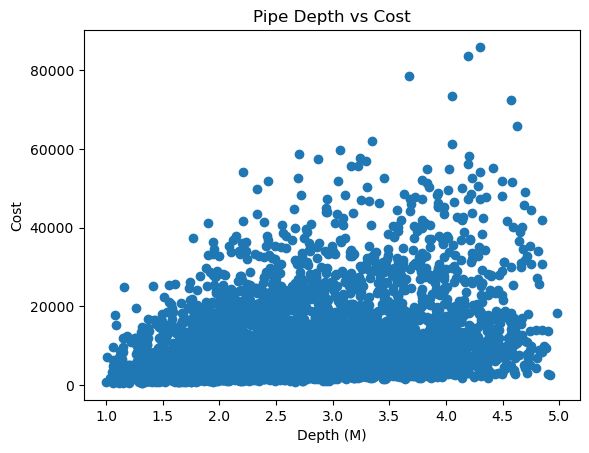

<Figure size 640x480 with 0 Axes>

In [12]:
# exploring how depth of the pipe impacts cost
plt.scatter(df_clean["DIAMETER_MM"], df_clean["JOB_COST"])
plt.xlabel("Diameter (mm)")
plt.ylabel("Cost")
plt.title("Pipe Diameter vs Job Cost (w/ outliers)")
plt.show()
plt.clf()

# it seems like there is a few outliers which are difficulting the data visualisation significantly
# I will need to remove them from the visualisation. 
# Since the 3rd quartile of this feature is at 200MM, I will define the upper limit at 500MM
df_diameter = df_clean[df_clean.DIAMETER_MM < 500]

# showing diameter visualisation
plt.scatter(df_diameter["DIAMETER_MM"], df_diameter["JOB_COST"])
plt.xlabel("Diameter (mm)")
plt.ylabel("Cost")
plt.title("Pipe Diameter vs Job Cost")
plt.show()
plt.clf()

# Now lets explore the impact pipe length has on cost.
plt.scatter(df_clean.LENGTH_M, df_clean.JOB_COST)
plt.xlabel("Length (M)")
plt.ylabel("Cost")
plt.title("Pipe length vs Cost")
plt.show()
plt.clf()

# Finally, depth
plt.scatter(df_clean.DEPTH_M, df_clean.JOB_COST)
plt.xlabel("Depth (M)")
plt.ylabel("Cost")
plt.title("Pipe Depth vs Cost")
plt.show()
plt.clf()

# I will keep this at above 0, as it seems there are a few outliers which were installed above ground
df_depth = df_clean[(df_clean.DEPTH_M > 0)]

plt.scatter(df_depth.DEPTH_M, df_depth.JOB_COST)
plt.xlabel("Depth (M)")
plt.ylabel("Cost")
plt.title("Pipe Depth vs Cost")
plt.show()
plt.clf()

Here we can see how outliers in the DIAMETER_MM variable are affecting the visualisation of the data. In order to achieve a better quality and retrieve insights from it, these values were removed from the visualisation (but not from the data set being analised).

Overall, it seems the variables Depth and Diameter both have a positive linear relationship with the Job Cost, whereas Length does not seem to have any sort of relationship. In order to assess this further, a Pearson's correlation test will be run for each of them.

In [13]:
# pipe diameter w/ outliers
corr, p_value = pearsonr(df_clean.DIAMETER_MM, df_clean.JOB_COST)
print('Pearsons correlation for Diameter (w/ outliers): %.3f' % corr)
print(f"With a p-value of {p_value}")

# pipe diameter w/o outliers
corr1, p_value1 = pearsonr(df_diameter.DIAMETER_MM, df_diameter.JOB_COST)
print('Pearsons correlation for Diameter (w/o outliers): %.3f' % corr1)
print(f"With a p-value of {p_value1}")

# pipe length
corr2, p_value2 = pearsonr(df_clean.LENGTH_M, df_clean.JOB_COST)
print('Pearsons correlation for Length: %.3f' % corr2)
print(f"With a p-value of {p_value2}")

# pipe depth - in this case I removed any values of jobs done above ground (i.e Depth < 0) from the correlation, 
# this is because these jobs are, arguably, completely different operations. As with the diameter, I ran tests with and without
# outliers. In this case it seems to not have affected the relationship.

corr3, p_value3 = pearsonr(df_clean.DEPTH_M, df_clean.JOB_COST)
print('Pearsons for depth w/ outliers: %.3f' % corr3)
print(f"With a p-value of {p_value3}")

corr4, p_value4 = pearsonr(df_depth.DEPTH_M, df_depth.JOB_COST)
print('Pearsons for depth w/o outliers: %.3f' % corr4)
print(f"With a p-value of {p_value4}")

Pearsons correlation for Diameter (w/ outliers): -0.007
With a p-value of 0.6108430113171605
Pearsons correlation for Diameter (w/o outliers): 0.718
With a p-value of 0.0
Pearsons correlation for Length: 0.180
With a p-value of 1.1104714620444236e-37
Pearsons for depth w/ outliers: 0.337
With a p-value of 1.4177004627626773e-132
Pearsons for depth w/o outliers: 0.343
With a p-value of 1.6331595282537977e-137


Once again, it seems the outlier in the DIAMETER_MM column are impacting the relationship between this variable and the JOB_COST feature very significantly. As such, I removed them from the analysis.

From the Pearson's Correlation we can now see that, when outliers are removed, the Diameter feature indeed has the strongest relationship with the cost of a job, followed by the depth (low correlation) and then the length (very low). However, from this test we now understand that each of these pipe features do impact the cost each intervention carries.

Overall, it seems that, as expected, the cost of a job is dependent, to some extent at least, on each one of the features present in the dataset. With this information, we can now progress by developing an approach that will alow users to predict the cost of the job.

<a id="prediction"></a>
# An approach for predicting job cost

There could be many different approaches to prophylactically determine the cost of jobs. For example, a set amount could be determined for the Repair and the Replace job types (perhaps using the mean of the cost carried in the previous job, by each of these types).

However, in this project, we have elected to use a Machine Learning algorithm that will utilise the features in the dataset to accurately predict the cost of future jobs.

<a id="XGBoost"></a>
## The XGBoost Algorithm

As one of the most popular machine learning algorithms, XGBoost is an ensemble algorithm. This means it takes in the predictions of various repetitions of the Decision-Tree ML algorithm and averages them, this way obtaining the final values. 

Furthermore, by using the cross\_val\_score function, we are dividing the dataset into 5 parts (~1000 observations per subset), and calculating the error for each one, which then allows us to calculate the root mean squared error (a common error measure in ML) of the algorithm, as a popular form of evaluating the model.

Meaning, we will use this algorithm to make predictions for the "JOB\_COST" variable and then "test" them against the real values. The difference between the two will then contribute to the error measure and determine the confidence we have in deploying it in the future.

In [14]:
# encoding categorical data
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit MATERIAL
# encoder and return encoded label
label = le.fit_transform(df_clean['MATERIAL'])
label1 = le.fit_transform(df_clean["JOB_TYPE"])

df_ML1 = df_clean.drop(columns = ["MATERIAL", "JOB_TYPE"], inplace = False)
df_ML1["MATERIAL"] = label
df_ML1["JOB_TYPE"] = label1

# Dropping Job_ID
df_ML1.drop(columns = "JOB_ID", inplace=True)

# some feature engineering
df_ML1["DIAMETER_M"] = df_ML1["DIAMETER_MM"]/1000
df_ML1 = df_ML1.drop(columns = "DIAMETER_MM")
df_ML1['VOLUME_M'] = math.pi * ((df_ML1["DIAMETER_M"]/2)**2) * df_ML1["LENGTH_M"]

print(df_ML1)
print(df_clean)
# Dividing the target variable from the rest of the dataset
y = df_ML1["JOB_COST"]
X = df_ML1.drop(columns = "JOB_COST")

# using GXBoost to predict job cost
scores = cross_val_score(XGBRegressor(eta=0.1, gamma = 0.5, max_depth = 5, subsample = 0.5),
                         X, y, scoring='neg_mean_squared_error')

# finding the mean squared error of the algorithm
root_mse = (-scores)**0.5
print(root_mse.mean())

      DEPTH_M  LENGTH_M      JOB_COST  MATERIAL  JOB_TYPE  DIAMETER_M  \
0        2.19     31.55  19847.644300         2         1       0.200   
1        2.27     15.14   4476.588985         0         1       0.063   
2        3.64     15.17  16871.484850         2         0       0.450   
3        2.28     15.64  11158.144200         0         1       0.200   
4        2.40     39.23  16913.611580         2         1       0.200   
...       ...       ...           ...       ...       ...         ...   
4995     2.06     23.34   9846.054169         0         1       0.125   
4996     2.17     28.22  16475.714440         0         1       0.250   
4997     3.01     18.39   1617.823411         0         0       0.050   
4998     2.75     34.72   5313.796675         1         1       0.050   
4999     4.31     30.03  15870.566110         0         1       0.090   

      VOLUME_M  
0     0.991172  
1     0.047195  
2     2.412684  
3     0.491345  
4     1.232447  
...        ...  
4995

## Results of the XGBoost application

As can be seen above, the root mean squared error of this algorithm averaged at 1723.87£. This is an incredibly accurate algorithm, as there are very close to 5000 datapoints in the dataset used (a reminder of the 6 NaNs we encountered earlier, which were not included in the dataset just yet). Meaning that, after spliting the dataset in half for a "Train" and a "Test" datasets, there were 2500 datapoints being tested against. As such, the algorithm made an average error of 0.68£ per datapoint!

Because this is a very accurate algorithm we will now use it to make predictions for the Cost of the 6 datapoints that were lacking a Cost and will then be comparing these jobs with ones that cost similar values to the ones determined by the algorithm, in an attempt to further validate the model.

<a id="application"></a>
### Applying the model

In [15]:
# identifying the 6 datapoints again
df_nan = df[df.JOB_COST.isna()]
print(df_nan)

# applying to it the same operations done to the other datapoints (i.e Feature Engineering)
# encoding categorical data
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit MATERIAL
# encoder and return encoded label
label = le.fit_transform(df_nan['MATERIAL'])
label1 = le.fit_transform(df_nan["JOB_TYPE"])

df_nan_ML = df_nan.drop(columns = ["MATERIAL", "JOB_TYPE"], inplace = False)
df_nan_ML["MATERIAL"] = label
df_nan_ML["JOB_TYPE"] = label1

# Dropping Job_ID
df_nan_ML.drop(columns = "JOB_ID", inplace=True)

# some feature engineering
df_nan_ML["DIAMETER_M"] = df_nan_ML["DIAMETER_MM"]/1000
df_nan_ML = df_nan_ML.drop(columns = "DIAMETER_MM")
df_nan_ML['VOLUME_M'] = math.pi * ((df_nan_ML["DIAMETER_M"]/2)**2) * df_nan_ML["LENGTH_M"]

# Dividing the target variable from the rest of the dataset
y_nan = df_nan_ML["JOB_COST"]
X_nan = df_nan_ML.drop(columns = "JOB_COST")

# Predicting the cost of the jobs
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.25, random_state=42)

# setting up the model
xgbr = xgb.XGBRegressor(eta=0.1, gamma = 0.5, max_depth = 5, subsample = 0.5)

# fitting the model to our dataset
xgbr = xgbr.fit(X_train, y_train)

# predicting the Job_Cost values
y_nan = xgbr.predict(X_nan)

# creating a new dataframe with our new, predicted values

# I will create a new dataset in order to avoid replacing the old one
df_final = df.copy()

# firstly, checking the NaNs are in this new dataset - they are
print(df_final["JOB_COST"].isna().sum())

# getting the index of the NaNs
df_nan_index = df[df.JOB_COST.isna()].index
print(list(df_nan_index))

# updating the NaN values with the predicted values by the GXBoost model
df_final.loc[df_nan_index, ["JOB_COST"]] = y_nan
print(df_final["JOB_COST"].isna().sum())

        JOB_ID JOB_TYPE  DEPTH_M  DIAMETER_MM MATERIAL  LENGTH_M  JOB_COST
67      Job 68  Replace     1.47           90       AC     44.04       NaN
102    Job 103  Replace     2.86          125       ST     20.97       NaN
405    Job 406  Replace     1.62           90       CI     29.81       NaN
1233  Job 1234   Repair     1.93          250       AC     20.57       NaN
3240  Job 3241  Replace     3.15           90       AC     41.94       NaN
4557  Job 4558  Replace     2.13           50       ST     19.21       NaN
6
[67, 102, 405, 1233, 3240, 4557]
0


#### We now have used a Machine Learning algorithm (XGBoost) to predict the 6 missing values from the DataFrame, this way building a model for Job Cost prediction in the future. 

### Validating the model

All that is left now is to validate these 6 values. We will do so by visualising datapoints in the same level of Job Cost as these 6 datapoints, and comparing their specifications to these other datapoints, in an attempt to determine wether they were misplaced or not.

In [16]:
# Visualising the six datapoints again
print(df_final.loc[df_nan_index])

# In order to visualise them, lets observe each datapoint individually

# Job 68 - It seems this datapoint fits well with its surrounding peers
# (uncomment print statement to see some of them)
job_68 = df_final.loc[(df_final.JOB_COST > 6200) & (df_final.JOB_COST < 6300)]
#print(job_68.head(10))
#print(df_final.loc[67])
#print(job_68.describe())

# Job 103 - This datapoint also seems to be well placed in the dataset, when compared to its peers
job_103 = df_final.loc[(df_final.JOB_COST > 11800) & (df_final.JOB_COST < 12300)]
#print(df_final.loc[102])
#print(job_103.head(10))
#print(job_103.describe())

# Job 406 - Same thing with this one
job_406 = df_final.loc[(df_final.JOB_COST > 5250) & (df_final.JOB_COST < 5750)]
#print(df_final.loc[405])
#print(job_406.head(10))
#print(job_406.describe())

# Job 1234
job_1234 = df_final.loc[(df_final.JOB_COST > 4250) & (df_final.JOB_COST < 4750)]
#print(df_final.loc[1233])
#print(job_1234.head(10))
#print(job_1234.describe())

# Job 3241
job_3241 = df_final.loc[(df_final.JOB_COST > 12500) & (df_final.JOB_COST < 13000)]
#print(df_final.loc[3240])
#print(job_3241.head(10))
#print(job_3241.describe())

# Job 4557
job_4557 = df_final.loc[(df_final.JOB_COST > 3400) & (df_final.JOB_COST < 4000)]
#print(df_final.loc[4556])
#print(job_4557.head(10))
#print(job_4557.describe())

        JOB_ID JOB_TYPE  DEPTH_M  DIAMETER_MM MATERIAL  LENGTH_M      JOB_COST
67      Job 68  Replace     1.47           90       AC     44.04   5577.140137
102    Job 103  Replace     2.86          125       ST     20.97  12703.760742
405    Job 406  Replace     1.62           90       CI     29.81   6022.500000
1233  Job 1234   Repair     1.93          250       AC     20.57   5853.422852
3240  Job 3241  Replace     3.15           90       AC     41.94  12755.233398
4557  Job 4558  Replace     2.13           50       ST     19.21   3660.051025


Since all 6 datapoints seem to fit in well with their peers, we have successfully developed a method for predicting job cost in the future, thus increasing the reliability and predictability of future job evaluations.

Using this model, users will now be able to access an accurate ballpark for the cost of the operation they are requiring, this way increasing the productivity and effectiveness of our company by many levels.

<a id="tool"></a>
# A Tool for Users to Interact With

In order for users to make full use of the model built in this report, as well as being able to explore the data in a simplified way, a tool is required.

Below, the user can find such a tool. To use it, simply run the below cell code and input the values it requests.

In [ ]:
def fitting(df_final):
    # applying to it the same operations done to the other datapoints (i.e Feature Engineering)
    # encoding categorical data
    # Creating a instance of label Encoder.
    le = LabelEncoder()
 
    # Using .fit_transform function to fit MATERIAL
    # encoder and return encoded label
    label = le.fit_transform(df_final['MATERIAL'])
    label1 = le.fit_transform(df_final["JOB_TYPE"])

    df_final_ML = df_final.drop(columns = ["MATERIAL", "JOB_TYPE"], inplace = False)
    df_final_ML["MATERIAL"] = label
    df_final_ML["JOB_TYPE"] = label1

    # Dropping Job_ID
    df_final_ML.drop(columns = "JOB_ID", inplace=True)

    # some feature engineering
    df_final_ML["DIAMETER_M"] = df_final_ML["DIAMETER_MM"]/1000
    df_final_ML = df_final_ML.drop(columns = "DIAMETER_MM")
    df_final_ML['VOLUME_M'] = math.pi * ((df_final_ML["DIAMETER_M"]/2)**2) * df_final_ML["LENGTH_M"]

    # Dividing the target variable from the rest of the dataset
    y = df_final_ML["JOB_COST"]
    X = df_final_ML.drop(columns = "JOB_COST")

    
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.25, random_state=42)

    # setting up the model
    xgbr = xgb.XGBRegressor(eta=0.1, gamma = 0.5, max_depth = 5, subsample = 0.5)

    # fitting the model to our dataset
    xgbr = xgbr.fit(X_train, y_train)
    
    return xgbr

def prediction(df_new, xgbr = xgbr):
    
    # copying the specification, to avoid losing it
    df_new_ML = df_new.copy()
    
    # cleaning up the categorical variables
    cleanup = {"MATERIAL": {"AC": 0, "CI": 1, "ST": 2}, 
               "JOB_TYPE": {"Repair": 0, "Replace": 1}}
    df_new_ML = df_new_ML.replace(cleanup)
    
    # some feature engineering
    df_new_ML["DIAMETER_M"] = df_new_ML["DIAMETER_MM"]/1000
    df_new_ML = df_new_ML.drop(columns = "DIAMETER_MM")
    df_new_ML['VOLUME_M'] = math.pi * ((df_new_ML["DIAMETER_M"]/2)**2) * df_new_ML["LENGTH_M"]
    
    # Predicting the cost of the jobs using the model fitted in the previous function
    cost_prediction = xgbr.predict(df_new_ML)
    
    return cost_prediction

# This part of the code will request the user to input their specifications one by one
# It will then convert it into the required variable type and use defensive programming
# if the user does not follow what we need them to.

specifics = {}

print("----------------------------------------")
print("Welcome to the Pipe Installer Calculator")
print("----------------------------------------")

while True:
            print("\nFrom the following choices, plese indicate what the job type is:")
            print("|Repair|Replace|")
            job_type = input("Please indicate the job type - ")
            job_type = job_type.title()
            if job_type == "Repair" or job_type == "Replace":
                specifics["JOB_TYPE"] = job_type
            elif job_type != "Repair" or job_type != "Replace":
                raise Exception("Please input either Repair or Replace. Try again.")
            break

while True:
        try:
            print("\nPlease indicate the depth of the installation (M):")
            depth = float(input("What is the depth of the operation? - "))
            specifics["DEPTH_M"] = depth
            if depth > 6:
                raise Exception("We do not operate at deeper than 10 meters.")
            break
        except ValueError:
            print("Please indicate the depth in Meters.")

while True:
        try:
            print("\nThank you! Now tell us the diameter of the pipe(MM):")
            diameter = float(input("What is the diameter of the pipe? - "))
            specifics["DIAMETER_MM"] = diameter
            if diameter > 500:
                raise Exception("We do not have pipes that large in stock.")
            break
        except ValueError:
            print("Please indicate the depth in Milimeters.")
            
while True:
            print("\nGreat! From the following choices, please indicate the type of material:")
            print("|AC|ST|CI|")
            material = str(input("What is the pipe made out of? - "))
            material = material.upper()
            if material == "AC" or material == "CI" or material == "ST":
                specifics["MATERIAL"] = material
            elif material != "AC" or material != "CI" or material != "ST":
                raise Exception("Please input either AC, CI or ST as the material.")
            break

while True:
        try:
            print("\nFinally, tell us what the length of the pipe is(M):")
            length = float(input("What is the length of the pipe? - "))
            specifics["LENGTH_M"] = length
            if length > 55:
                print("We do not have pipes that long in stock.")
            break
        except ValueError:
            print("Please indicate the length in Meters.")

print(specifics)

df_new = pd.DataFrame(specifics, index = [0])
print(df_new)

xgbr = fitting(df_final)
cost_prediction = str(prediction(df_new, xgbr))

print("\n--------------------------------------------------------------------")
print("Calculating job cost...")
print(f"Based on the specifics for this job:\n {df_new}\n The total cost of this job is (initially) predicted to be {cost_prediction}£.")

----------------------------------------
Welcome to the Pipe Installer Calculator
----------------------------------------

From the following choices, plese indicate what the job type is:
|Repair|Replace|


<a id="discussion"></a>
# Discussion

This report aimed to answer the following questions:

- Describe the data provided.
- Show how the cost of jobs is related to other features in the data.
- Develop an approach for predicting the cost of a job.
- Wireframe a tool empowering users to interact with any outcomes. - This will be done externaly to this notebook.

It successufuly demonstrated how certain features have a bigger impact on the cost of a job, as well as to which extent they do so. Furthermore, it successfuly developed a model for predicting the cost of said job, so that future users (both internally and externally) are capable of making better informed decisions.